   # Convolutional Neural Networks with Pytorch 
   
   - Developed by **Armin Norouzi**
   - Compatible with Google Colaboratory- Pytorch version 1.12.1+cu113

   
   - **Objective:** Create full Convolutional Neural Networks and train it for image classification
   
   
**Table of content:**

1. CNN model - MNIST dataset
2. CNN model - CIFAR dataset




# CNN model - MNIST dataset

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import seaborn as sn  # for heatmaps
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

## Load the MNIST dataset
PyTorch makes the MNIST dataset available through <a href='https://pytorch.org/docs/stable/torchvision/index.html'><tt><strong>torchvision</strong></tt></a>. The first time it's called, the dataset will be downloaded onto your computer to the path specified. From that point, torchvision will always look for a local copy before attempting another download.

 

### Define transform
As part of the loading process, we can apply multiple transformations (reshape, convert to tensor, normalize, etc.) to the incoming data.<br>For this exercise we only need to convert images to tensors.

In [ ]:
transform = transforms.ToTensor()

### Load the training and testing set

In [ ]:
train_data = datasets.MNIST(root='../Data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='../Data', train=False, download=True, transform=transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../Data/MNIST/raw/train-images-idx3-ubyte.gz to ../Data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../Data/MNIST/raw/train-labels-idx1-ubyte.gz to ../Data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../Data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../Data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../Data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../Data/MNIST/raw



In [ ]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [ ]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../Data
    Split: Test
    StandardTransform
Transform: ToTensor()

Calling the first record from train_data returns a two-item tuple. The first item is our 28x28 tensor representing the image. The second is a label, in this case the number "5".

In [ ]:
image, label = train_data[0]
print('Shape:', image.shape, '\nLabel:', label)

Shape: torch.Size([1, 28, 28]) 
Label: 5


### View the image

Matplotlib can interpret pixel values through a variety of <a href='https://matplotlib.org/tutorials/colors/colormaps.html'>colormaps</a>.

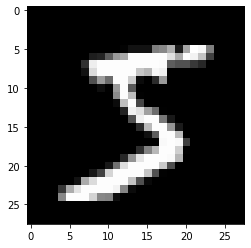

In [ ]:
plt.imshow(train_data[0][0].reshape((28,28)), cmap="gray");

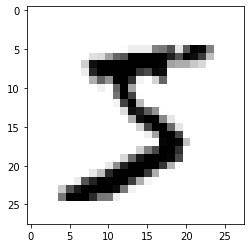

In [ ]:
plt.imshow(train_data[0][0].reshape((28,28)), cmap="gist_yarg");


## Batch loading with DataLoader
Our training set contains 60,000 records. Lets load training data in batches using <a href='https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader'><tt><strong>DataLoader</strong></tt></a>. When working with images, we want relatively small batches; a batch size of 4 is not uncommon.

In [ ]:
torch.manual_seed(101)  # for consistent results

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)

test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

In the cell above, <tt><strong>train_data</strong></tt> is a PyTorch <a href='https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset'><em>Dataset</em></a> object (an object that supports data loading and sampling).<br>
The <tt><strong>batch_size</strong></tt> is the number of records to be processed at a time. If it's not evenly divisible into the dataset, then the final batch contains the remainder.<br>
Setting <tt><strong>shuffle</strong></tt> to True means that the dataset will be shuffled after each epoch.

<div class="alert alert-info"><strong>NOTE:</strong> DataLoader takes an optional <tt><strong>num_workers</strong></tt> parameter that sets up how many subprocesses to use for data loading. This behaves differently with different operating systems so we've omitted it here. See <a href='https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader'>the docs</a> for more information.</div>

### View a batch of images
Once we've defined a DataLoader, we can create a grid of images using <a href='https://pytorch.org/docs/stable/torchvision/utils.html#torchvision.utils.make_grid'><tt><strong>torchvision.utils.make_grid</strong></tt></a>

Labels:  [7 2 3 5 8 5 3 6 9 9 1 3 5 5 4 5]


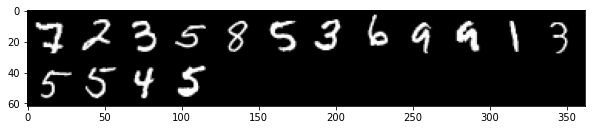

In [ ]:
from torchvision.utils import make_grid

# Grab the first batch of images
for images,labels in train_loader: 
    break

# Print the first 12 labels
print('Labels: ', labels.numpy())

# Print the first 12 images
im = make_grid(images, nrow=12)  # the default nrow is 8
plt.figure(figsize=(10,4))
# We need to transpose the images from CWH to WHC
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

## Define a convolutional model

### How Conv2d layers

`torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)`

- `in_channels (int)` – Number of channels in the input image

- `out_channels (int)` – Number of channels produced by the convolution

- `kernel_size (int or tuple)` – Size of the convolving kernel

- `stride (int or tuple, optional)` – Stride of the convolution. Default: 1

- `padding (int, tuple or str, optional)` – Padding added to all four sides of the input. Default: 0

- `padding_mode (string, optional)` – `'zeros'`, `'reflect'`, `'replicate'` or `'circular'`. Default: 'zeros'

- `dilation (int or tuple, optional)` – Spacing between kernel elements. Default: 1

- `groups (int, optional)` – Number of blocked connections from input channels to output channels. Default: 1

- `bias (bool, optional)` – If True, adds a learnable bias to the output. Default: True

In [ ]:
# Define layers
conv1 = nn.Conv2d(1, 6, 3, 1)
# 1 -- > As we have gray scale images, we have only one input chanel
# 6 -- > This is number of filters, we have 6 filters
# 3 -- > we have 3 by 3 filter
# 1 -- > 1 is stride
conv2 = nn.Conv2d(6, 16, 3, 1)
# 6 -- > as we had 6 filter in conv1, input is 6
# 16 -- > This is number of filters, we have 16 filters
# 3 -- > we have 3 by 3 filter
# 1 -- > 1 is stride

In [ ]:
# Grab the first MNIST record
for i, (X_train, y_train) in enumerate(train_data):
    break

In [ ]:
# Create a rank-4 tensor to be passed into the model
# (train_loader will have done this already)
x = X_train.view(1,1,28,28) # x is one image
print(x.shape)

torch.Size([1, 1, 28, 28])


In [ ]:
# Perform the first convolution/activation
x = F.relu(conv1(x))
print(x.shape)

torch.Size([1, 6, 26, 26])


- `1` = as we have one single images 
- `6` = as we had 6 filter 
- `26 * 26` = because we used zero padding so we are loosing soem information from boarder

In [ ]:
# Run the first pooling layer
x = F.max_pool2d(x, 2, 2)
print(x.shape)

torch.Size([1, 6, 13, 13])


- Maxpolling layer 2 mean we are reducing size `26 * 26` by `2 * 2` filter

In [ ]:
# Perform the second convolution/activation
x = F.relu(conv2(x))
print(x.shape)

torch.Size([1, 16, 11, 11])


- `1` = as we have one single images 
- `16` = as we had 16 filter 
- `11 * 11` = because we used zero padding so we are loosing soem information from boarder

In [ ]:
# Run the second pooling layer
x = F.max_pool2d(x, 2, 2)
print(x.shape)

torch.Size([1, 16, 5, 5])


- Maxpolling layer 2 mean we are reducing size `11 * 11` by `5 * 5` filter
- ` 11 / 2` is 5.5 but maxpolling round down it --> `11 // 2 = 5 `

In [ ]:
# Flatten the data
x = x.view(-1, 5*5*16)
print(x.shape)

torch.Size([1, 400])


- `-1`--> means keep the firs dimention of images, in our case is 1 as it is for one signle images
- `16, 5, 5` comes from last layer before flatten

### Building model

let's but all togheter


In [ ]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # Set up the convolutional layers with torch.nn.Conv2d()
        # The first layer has one input channel (the grayscale color channel).
        # We'll assign 6 output channels for feature extraction. We'll set our 
        # kernel size to 3 to make a 3x3 filter, and set the step size to 1.
        self.conv1 = nn.Conv2d(1, 6, 3, 1)

        # The second layer will take our 6 input channels and deliver 16 output channels.
        self.conv2 = nn.Conv2d(6, 16, 3, 1)

        # Set up the fully connected layers with torch.nn.Linear()

        # The input size of (5x5x16) is determined by the effect of our kernels on the input image size.
        # A 3x3 filter applied to a 28x28 image leaves a 1-pixel edge on all four sides. In one layer 
        # the size changes from 28x28 to 26x26. We could address this with zero-padding, but since an 
        # MNIST image is mostly black at the edges, we should be safe ignoring these pixels. We'll apply 
        # the kernel twice, and apply pooling layers twice, so our resulting output will be  
        # (((28−2)/2)−2)/2=5.5  which rounds down to 5 pixels per side.
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,10)

    def forward(self, X):

        # Activations can be applied to the convolutions in one line using F.relu() and pooling is done 
        # using F.max_pool2d() 
        # PyTorch handle pooling as activation rather than layer, that's the reason we've added here
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        # Flatten the data for the fully connected layers:
        X = X.view(-1, 5*5*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [ ]:
torch.manual_seed(42)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Including the bias terms for each layer, the total number of parameters being trained is:<br>

$\quad\begin{split}(1\times6\times3\times3)+6+(6\times16\times3\times3)+16+(400\times120)+120+(120\times84)+84+(84\times10)+10 &=\\
54+6+864+16+48000+120+10080+84+840+10 &= 60,074\end{split}$<br>

In [ ]:
def count_parameters(model):
    ''' This function used for counting number of parameters

    Arg:
      Model (PyTorch object)

    Return:
      print number of paramteres in each layer and sum of laerning parameter number
    '''
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [ ]:
count_parameters(model)

    54
     6
   864
    16
 48000
   120
 10080
    84
   840
    10
______
 60074


## Define loss function & optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Train the model
This time we'll feed the data directly into the model without flattening it first.

In [ ]:
import time
start_time = time.time()

epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1
        
        # Apply the model
        y_pred = model(X_train)  # we don't flatten X-train here
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%1000 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/60000]  loss: {loss.item():10.8f}')
        
    train_losses.append(loss.detach().numpy())
    train_correct.append(trn_corr.detach().numpy())
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss.detach().numpy())
    test_correct.append(tst_corr.detach().numpy())
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            

epoch:  0  batch: 1000 [ 10000/60000]  loss: 0.66229165
epoch:  0  batch: 2000 [ 20000/60000]  loss: 0.01290415
epoch:  0  batch: 3000 [ 30000/60000]  loss: 0.09723970
epoch:  1  batch: 1000 [ 10000/60000]  loss: 0.05072124
epoch:  1  batch: 2000 [ 20000/60000]  loss: 0.01193699
epoch:  1  batch: 3000 [ 30000/60000]  loss: 0.00154264
epoch:  2  batch: 1000 [ 10000/60000]  loss: 0.01364101
epoch:  2  batch: 2000 [ 20000/60000]  loss: 0.01508053
epoch:  2  batch: 3000 [ 30000/60000]  loss: 0.01658336
epoch:  3  batch: 1000 [ 10000/60000]  loss: 0.00120270
epoch:  3  batch: 2000 [ 20000/60000]  loss: 0.00438918
epoch:  3  batch: 3000 [ 30000/60000]  loss: 0.00234172
epoch:  4  batch: 1000 [ 10000/60000]  loss: 0.00397162
epoch:  4  batch: 2000 [ 20000/60000]  loss: 0.07158402
epoch:  4  batch: 3000 [ 30000/60000]  loss: 0.00043703
epoch:  5  batch: 1000 [ 10000/60000]  loss: 0.13094078
epoch:  5  batch: 2000 [ 20000/60000]  loss: 0.08714615
epoch:  5  batch: 3000 [ 30000/60000]  loss: 0.0

## Plot the loss and accuracy comparisons

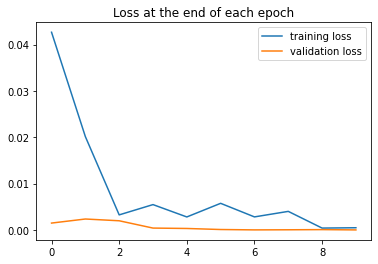

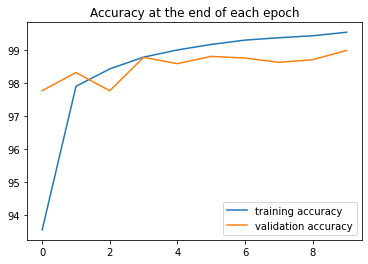

In [ ]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend()
plt.show();

plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend()
plt.show();

## Evaluate Test Data

In [ ]:
# Extract the data all at once, not in batches
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)  # we don't flatten the data this time
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 9899/10000 =  98.990%


### Display the confusion matrix

In [ ]:
# print a row of values for reference
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()

# print the confusion matrix
print(confusion_matrix(predicted.view(-1), y_test.view(-1)))

[[   0    1    2    3    4    5    6    7    8    9]]

[[ 974    0    2    0    0    0    3    1    2    0]
 [   0 1132    1    1    2    0    1    5    0    0]
 [   0    1 1019    2    1    0    1    2    2    0]
 [   0    0    1  994    0    3    0    0    1    1]
 [   0    0    1    0  971    0    1    0    0    4]
 [   0    0    0    4    0  887    2    0    0    3]
 [   2    1    0    0    1    1  948    0    0    0]
 [   2    0    7    2    0    1    0 1016    1    6]
 [   2    1    1    5    0    0    2    1  965    2]
 [   0    0    0    2    7    0    0    3    3  993]]


## Examine the misses
We can track the index positions of "missed" predictions, and extract the corresponding image and label. We'll do this in batches to save screen space.

In [ ]:
misses = np.array([])
for i in range(len(predicted.view(-1))):
    if predicted[i] != y_test[i]:
        misses = np.append(misses,i).astype('int64')
        
# Display the number of misses
len(misses)

101

In [ ]:
# Set up an iterator to feed batched rows
r = 12   # row size
row = iter(np.array_split(misses,len(misses)//r+1))

Index: [  18  247  321  340  381  445  448  495  582  659  740  924]
Label: [   3    4    2    5    3    6    9    8    8    2    4    2]
Guess: [   8    2    7    3    2    0    8    0    2    7    9    7]


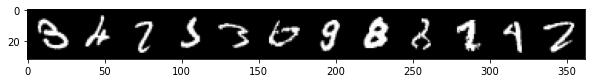

In [ ]:
nextrow = next(row)
print("Index:", nextrow)
print("Label:", y_test.index_select(0,torch.tensor(nextrow)).numpy())
print("Guess:", predicted.index_select(0,torch.tensor(nextrow)).numpy())

images = X_test.index_select(0,torch.tensor(nextrow))
im = make_grid(images, nrow=r)
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

## Run a new image through the model
We can also pass a single image through the model to obtain a prediction.
Pick a number from 0 to 9999, assign it to "x", and we'll use that value to select a number from the MNIST test set.

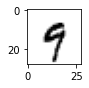

In [ ]:
x = 2019
plt.figure(figsize=(1,1))
plt.imshow(test_data[x][0].reshape((28,28)), cmap="gist_yarg");


In [ ]:
model.eval()
with torch.no_grad():
    new_pred = model(test_data[x][0].view(1,1,28,28)).argmax()
print("Predicted value:",new_pred.item())

Predicted value: 9


# CNN model - CIFAR dataset

## Load the CIFAR dataset

The <a href='https://en.wikipedia.org/wiki/CIFAR-10'>CIFAR-10</a> dataset is similar to MNIST, except that instead of one color channel (grayscale) there are three channels (RGB).<br>
Where an MNIST image has a size of (1,28,28), CIFAR images are (3,32,32). There are 10 categories an image may fall under:
0. airplane
1. automobile
2. bird
3. cat
4. deer
5. dog
6. frog
7. horse
8. ship
9. truck

As with the previous code along, make sure to watch the theory lectures! You'll want to be comfortable with:
* convolutional layers
* filters/kernels
* pooling
* depth, stride and zero-padding

PyTorch makes the CIFAR-10 train and test datasets available through <a href='https://pytorch.org/docs/stable/torchvision/index.html'><tt><strong>torchvision</strong></tt></a>. The first time they're called, the datasets will be downloaded onto your computer to the path specified. From that point, torchvision will always look for a local copy before attempting another download.<br>The set contains 50,000 train and 10,000 test images.

Refer to the previous section for explanations of transformations, batch sizes and <a href='https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader'><tt><strong>DataLoader</strong></tt></a>.

In [ ]:
transform = transforms.ToTensor()

train_data = datasets.CIFAR10(root='../Data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='../Data', train=False, download=True, transform=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../Data/cifar-10-python.tar.gz to ../Data
Files already downloaded and verified


In [ ]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [ ]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../Data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [ ]:
torch.manual_seed(101)  # for reproducible results

train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

### Define strings for labels
We can call the labels whatever we want, so long as they appear in the order of 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'. Here we're using 5-character labels padded with spaces so that our reports line up later.

In [ ]:
class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']

### View the image

Matplotlib can interpret pixel values through a variety of <a href='https://matplotlib.org/tutorials/colors/colormaps.html'>colormaps</a>.

Label: [    1     5     8     1     6     1     6     3     7     9]
Class:    car   dog  ship   car  frog   car  frog   cat horse truck


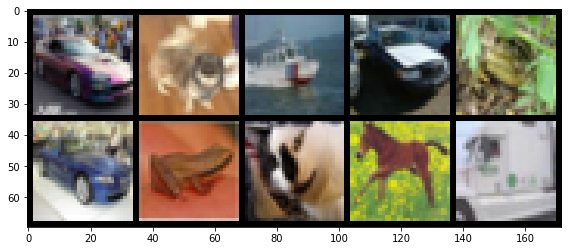

In [ ]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}')) # to widen the printed array

# Grab the first batch of 10 images
for images,labels in train_loader: 
    break

# Print the labels
print('Label:', labels.numpy())
print('Class: ', *np.array([class_names[i] for i in labels]))

# Print the images
im = make_grid(images, nrow=5)  # the default nrow is 8
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

## Define a convolutional model

### Building model


* take in 3-channel images instead of 1-channel
* adjust the size of the fully connected input<br>

Our first convolutional layer will have 3 input channels, 6 output channels, a kernel size of 3 (resulting in a 3x3 filter), and a stride length of 1 pixel.<br>These are passed in as <tt>nn.Conv2d(3,6,3,1)</tt


In [ ]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)  # changed from (1, 6, 5, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(6*6*16, 120)   # changed from (4*4*16) to fit 32x32 images with 3x3 filters
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 6*6*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

<div class="alert alert-info"><strong>Why <tt>(6x6x16)</tt> instead of <tt>(5x5x16)</tt>?</strong><br>
With MNIST the kernels and pooling layers resulted in $\;(((28−2)/2)−2)/2=5.5 \;$ which rounds down to 5 pixels per side.<br>
With CIFAR the result is $\;(((32-2)/2)-2)/2 = 6.5\;$ which rounds down to 6 pixels per side.</div>

In [ ]:
torch.manual_seed(101)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
count_parameters(model)

   162
     6
   864
    16
 69120
   120
 10080
    84
   840
    10
______
 81302


## Define loss function & optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Train the model
This time we'll feed the data directly into the model without flattening it first.

In [ ]:
import time
start_time = time.time()

epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1
        
        # Apply the model
        y_pred = model(X_train)  # we don't flatten X-train here
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%1000 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/60000]  loss: {loss.item():10.8f}')
        
    train_losses.append(loss.detach().numpy())
    train_correct.append(trn_corr.detach().numpy())
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss.detach().numpy())
    test_correct.append(tst_corr.detach().numpy())
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            

epoch:  0  batch: 1000 [ 10000/60000]  loss: 1.74091792
epoch:  0  batch: 2000 [ 20000/60000]  loss: 2.28505325
epoch:  0  batch: 3000 [ 30000/60000]  loss: 1.41110420
epoch:  0  batch: 4000 [ 40000/60000]  loss: 1.77556062
epoch:  0  batch: 5000 [ 50000/60000]  loss: 0.87544328
epoch:  1  batch: 1000 [ 10000/60000]  loss: 1.40881562
epoch:  1  batch: 2000 [ 20000/60000]  loss: 1.13322639
epoch:  1  batch: 3000 [ 30000/60000]  loss: 1.45552599
epoch:  1  batch: 4000 [ 40000/60000]  loss: 1.10780263
epoch:  1  batch: 5000 [ 50000/60000]  loss: 1.01513064
epoch:  2  batch: 1000 [ 10000/60000]  loss: 1.21744430
epoch:  2  batch: 2000 [ 20000/60000]  loss: 0.94388628
epoch:  2  batch: 3000 [ 30000/60000]  loss: 1.29108834
epoch:  2  batch: 4000 [ 40000/60000]  loss: 1.36637890
epoch:  2  batch: 5000 [ 50000/60000]  loss: 1.00823355
epoch:  3  batch: 1000 [ 10000/60000]  loss: 1.27289844
epoch:  3  batch: 2000 [ 20000/60000]  loss: 0.99568701
epoch:  3  batch: 3000 [ 30000/60000]  loss: 0.6

## Plot the loss and accuracy comparisons

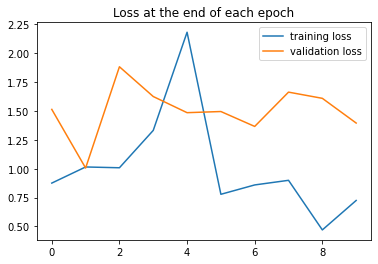

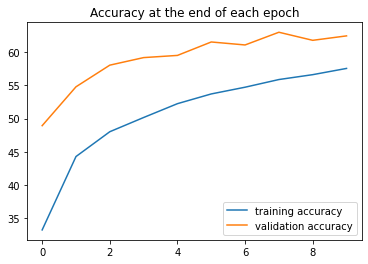

In [ ]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend()
plt.show();

plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend()
plt.show();

## Evaluate Test Data

In [ ]:
print(test_correct) # contains the results of all 10 epochs
print()
print(f'Test accuracy: {test_correct[-1].item()*100/10000:.3f}%') # print the most recent result as a percent

[array( 4893), array( 5480), array( 5807), array( 5921), array( 5954), array( 6157), array( 6112), array( 6304), array( 6182), array( 6249)]

Test accuracy: 62.490%


### Display the confusion matrix

In order to map predictions against ground truth, we need to run the entire test set through the model.<br>
Also, since our model was not as accurate as with MNIST, we'll use a <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>heatmap</a> to better display the results.

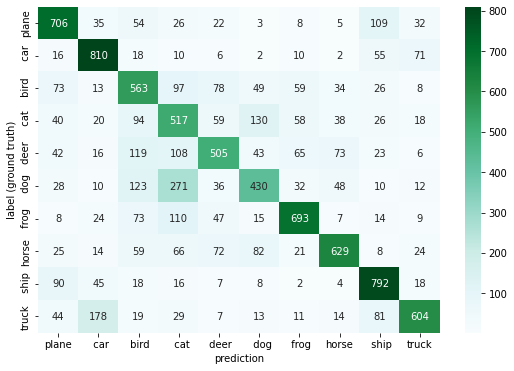

In [ ]:
# Create a loader for the entire the test set
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()

arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();

## Examine the misses
We can track the index positions of "missed" predictions, and extract the corresponding image and label. We'll do this in batches to save screen space.

In [ ]:
misses = np.array([])
for i in range(len(predicted.view(-1))):
    if predicted[i] != y_test[i]:
        misses = np.append(misses,i).astype('int64')
        
# Display the number of misses
len(misses)

3751

In [ ]:
# Set up an iterator to feed batched rows
r = 12   # row size
row = iter(np.array_split(misses,len(misses)//r+1))

Index: [    4    12    16    17    22    24    25    28    30    31    32    33]
Label: [    6     5     5     7     4     5     2     9     6     5     4     5]
Guess: [    4     1     3     3     2     4     4     1     3     3     2     3]


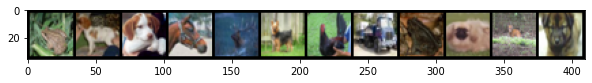

In [ ]:
nextrow = next(row)
print("Index:", nextrow)
print("Label:", y_test.index_select(0,torch.tensor(nextrow)).numpy())
print("Guess:", predicted.index_select(0,torch.tensor(nextrow)).numpy())

images = X_test.index_select(0,torch.tensor(nextrow))
im = make_grid(images, nrow=r)
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

## References: 

- [PyTorch for Deep Learning with Python Bootcamp](https://www.udemy.com/course/pytorch-for-deep-learning-with-python-bootcamp/) by [Jose Marcial Portilla](https://www.linkedin.com/in/jmportilla/)